<a href="https://colab.research.google.com/github/Tommo1818/CSC-357-Brain-AI/blob/main/CSC357_Lab3_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC357 Brain-Inspired Artificial Intelligence
## Lab 3 - Features in neural networks

This lab will examine visual features generated from a convolutional neural network and how they are used for object recognition (or classification).

**Please note that the answers from this lab need to be uploaded as a part of the coursework of CSC357. You can find the questions at the end of this notebook.**

We will examine how images are converted to feature maps across layers of a neural network, using AlexNet as an example. Similar analyses can also be conducted on other network models.

The lab will utilize PyTorch and the torchvision library. The latter offers common model architectures and their trained parameters. For more information, please refer to the official sites: [`PyTorch`](https://pytorch.org/) and [`Torchvision`](https://pytorch.org/vision).

Some codes used here are from a more detailed tutorial about Alexnet and PyTorch, which you can find [here](https://github.com/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb).

### 1. Load the model

In [ ]:
# Import all relevent libs
import os
import torch
import torch.nn
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
import numpy as np
import requests
from PIL import Image

In [ ]:
# Import the Alexnet model, using pre-trained weights. Note that the weights were trained using the Imagenet dataset.
# See https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html for further information
alexnet = models.alexnet(weights='DEFAULT');

# Here we focus on the application of the model (to classify images), not on the training of the model
# Hence we set the model in the evaluation mode
alexnet.eval();

# print the structure of the (trained) Alexnet
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

The codes above load a Alexnet model, pretrained using the ImageNet dataset. You can also see the structure of the model. The first few layers include several 2D convolutional layers, which are the focus of this lab.

**The standard Alexnet has the structure below:**

<img src='https://miro.medium.com/v2/resize:fit:1400/1*bD_DMBtKwveuzIkQTwjKQQ.png'/>

However, note that the model from Torchvision has a slightly different structure. In particular, the number of filters are different in the first layer (64 in Torchvision vs 96 in the original model). The difference does not affect the results of this lab.



---



<a name="inputimage"></a>
## 2. Load a test image and preprocessing

We have an image that we want to classify into its respective class. Since the model was trained on ImageNet with 1000 classes, we also import the class labels and then categorize the test image into ***one of the 1000 classes*** that the model was trained on.

**Test image** to download from [`Here`](http://ccbrain.org/images/CSC357/example_img.jpg), or you can use the code below to download directly to the current folder.

<img src="http://ccbrain.org/images/CSC357/example_img.jpg" width="400">


In [ ]:
# Download and load the image
img_data = requests.get('https://ccbrain.org/images/CSC357/example_img.jpg').content

with open('example_img.jpg', 'wb') as handler:
    handler.write(img_data)
img = Image.open('example_img.jpg')

# Download the class labels
class_data = requests.get('https://ccbrain.org/images/CSC357/class_names_ImageNet.txt').content
with open('class_imagenet.txt', 'wb') as handler:
    handler.write(class_data)

The model we just loaded was trained on pre-processed images that were normalized and croped with 224*224 pixels. Hence, we need to make sure that our test image is of the same size. For details of the preprocessing, see [THIS LINK](https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html).

To achieve this, we use a transform function below.

In [ ]:
data_preprocess = transforms.Compose([
        transforms.Resize((224,224), antialias=True),       # Resize the image to 224x224
        transforms.ToTensor(),              # put the input to tensor format
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # normalize the input, these specific parameters were used to train the model. Hence we apply them to the test iamge.
])

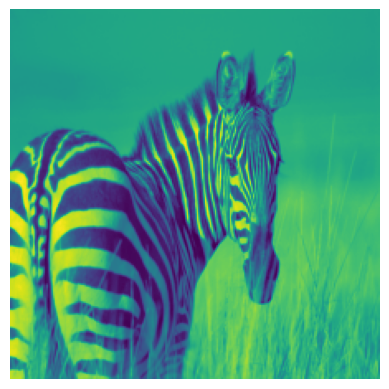

In [ ]:
# Apply the preprocessing transform to the test image and prepare a batch for testing

test_img = data_preprocess(img)
batch_img = torch.unsqueeze(test_img, 0)

# Visualise the preprocessed image. Note the change in size and color compared with the original image
fig = plt.figure();
plt.imshow(test_img[0].numpy());
plt.axis('off');



---



<a name="classification"></a>
## 3. Classify the image

We can use the simple code `alexnet(batch_img)` to test which category (class) the pre-trained AlexNet assigns to the test image.

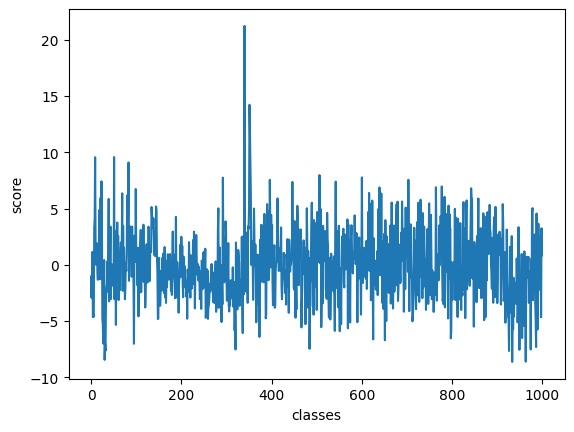

In [ ]:
output = alexnet(batch_img)

plt.plot(output.detach().numpy().transpose());
plt.xlabel('classes');
plt.ylabel('score');

The last (or output) layer of AlexNet has 1000 nodes, corresponding to the 1000 classes in ImageNet. Here, we obtained the scores assigned to each of the 1000 classes, as shown in the plot above. The higher the score, the more likely the model assigns the class to the test image.

We observe that a few classes have much higher scores. You can use the code below to print the top 5 classes based on their probability (obtained from a Softmax function applied to the class scores above). The result (hopefully) corresponds to the true class of the image.

In [ ]:
# map the class no. to the corresponding label
with open('class_imagenet.txt') as labels:
  classes = [i.strip() for i in labels.readlines()]

# sort the probability vector in descending order
sorted, indices = torch.sort(output, descending=True)
percentage = F.softmax(output, dim=1)[0] * 100.0

# obtain the top 5 classes (with the highest probability) the input belongs to
results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
print("The first 5 classes of the testing image and their probabilities are:\n------------------------------------------------")
for i in range(5):
  print('{}: {:.2f}%'.format(results[i][0], results[i][1]))


The first 5 classes of the testing image and their probabilities are:
------------------------------------------------
zebra: 99.90%
hartebeest: 0.09%
impala, Aepyceros melampus: 0.01%
triceratops: 0.00%
ostrich, Struthio camelus: 0.00%


---

<a name="1stlayer"></a>
## 4. Filters and feature maps in the 1st layer

In this section, we take a closer look at the (trained) filters in AlexNet's 1st layer. The codes below define functions to visualizes convolutional filters.

In [ ]:
# Just nomalize the image
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

# Visualise the filters
def plot_filters(filters, normalize=True):
    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        image = filters[i]
        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0)) # RGB channel needs to be the last dim for plotting
        ax.axis('off')
    fig.subplots_adjust(wspace=-0.9)

Now let's get all the 64 filters from the first layer and plot them.

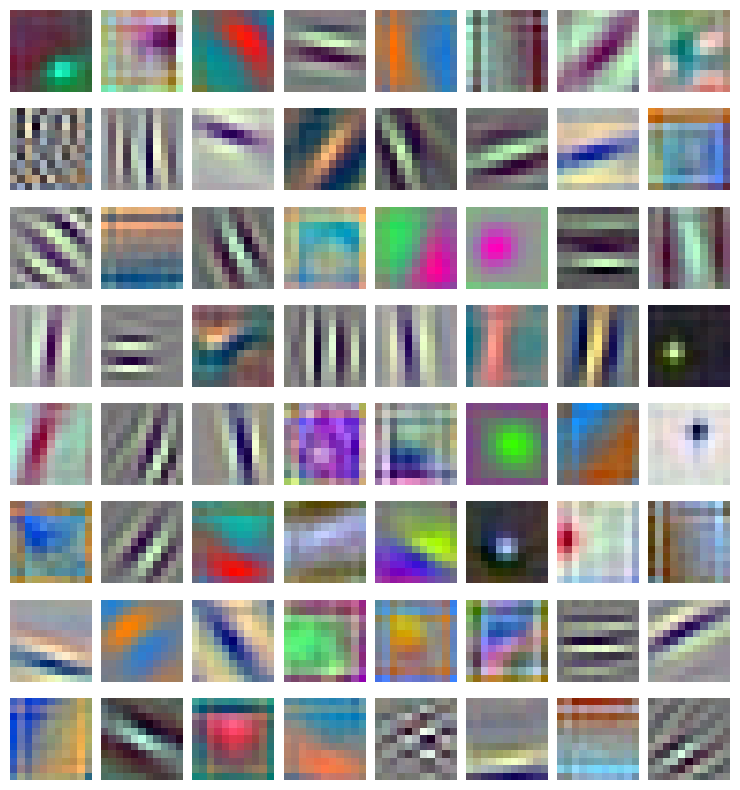

In [ ]:
# Here, features[0] refers to the first layer. Similarly, features[1] would refers to the next layer, ...
filters = alexnet.features[0].weight.data.clone();
plot_filters(filters);

**Some of the filters above are efficient in detecting specific orientations in the image. Can you spot them?**

During testing, each of the convolutional filter is applied to the test image, resulting a feature map of the image. The code below directly applies the 64 filters from the 1st layer to the test image.

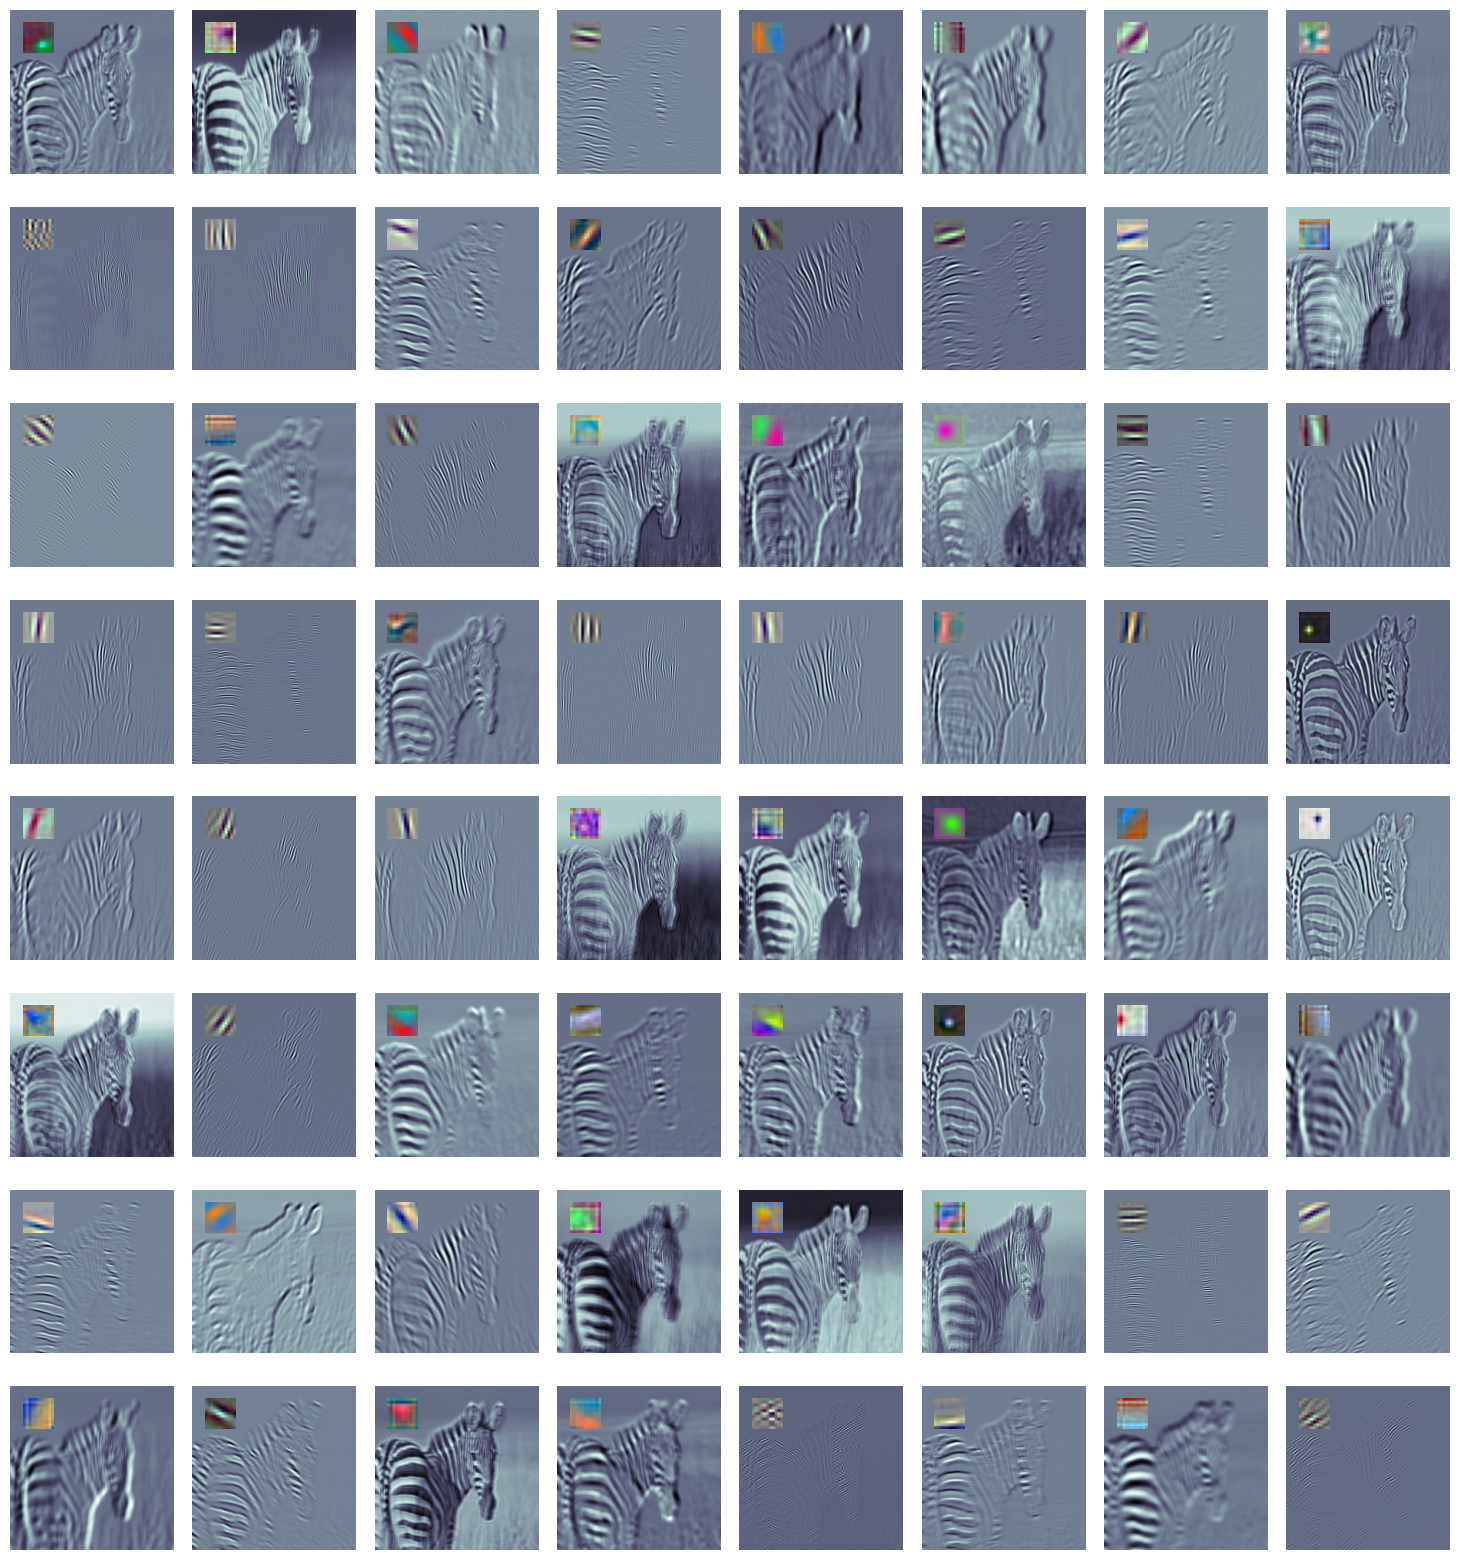

In [ ]:
filters = alexnet.features[0].weight.data.clone();

# Applying convolution operation
filtered_images = F.conv2d(batch_img, filters)

# Plot the filtered image
fig, axes = plt.subplots(8, 8, figsize=(40, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image = filtered_images[0][i]
    image = normalize_image(image)
    ax.imshow(image,cmap='bone')

    # overlay each filter used here
    imagebox = OffsetImage(normalize_image(filters[i]).permute(1, 2, 0).numpy(), zoom=2)
    ab = AnchoredOffsetbox(loc='upper left', child=imagebox, frameon=False)
    ax.add_artist(ab)
    ax.axis('off')

fig.subplots_adjust(wspace=-0.9)

Review the results displayed above along with their corresponding filters.

**Consider the influence of orientation-specific filters on the convoluted image.**

---

<a name="actmaps"></a>
## 5. Activation maps in later layers

In [Section 4](#1stlayer), we obtained 64 convoluted images from the 1st layer. The output of each convolutional layer is the combination of all convoluted images obtained at that layer.

We can visualize the averaged covoluted image after each layer, which provides the information on the important feastures (used by that layer) for classification. This can be done using the codes below.


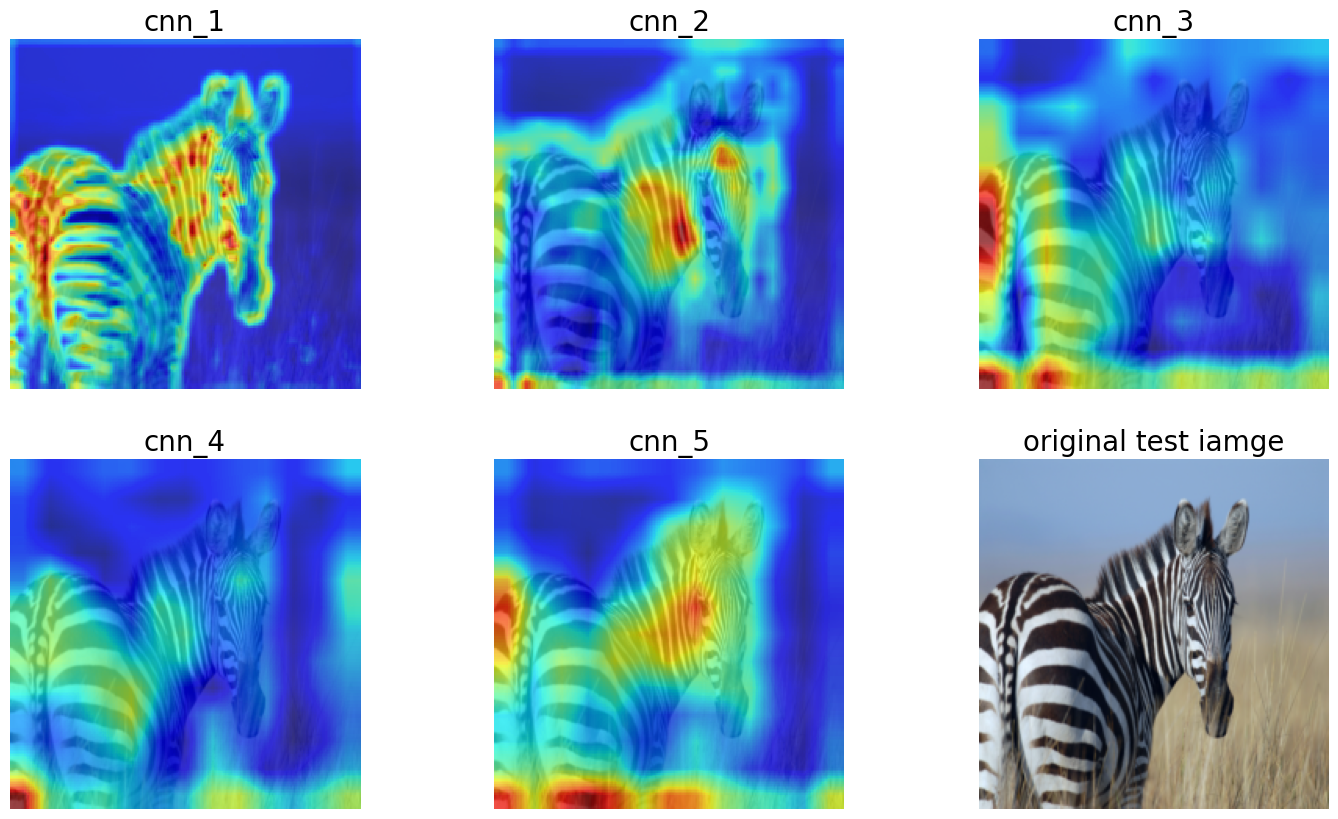

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().clone()
    return hook

#counter to keep count of the conv layers
counter = 0

# We loop though all layers and place a foward hook after each convolutional layer
# The hook is a handle that gives the (copied) value of a layer's activation
# More information about fowrad hooks is available here: https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch
model_children = list(alexnet.children())
model_children = model_children[0]
for i in range(len(model_children)):
    if type(model_children[i]) == torch.nn.Conv2d:
        counter+=1
        # NOTE: we acutally placed hooks at the ReLU layer to get cleaner maps
        model_children[i+1].register_forward_hook(get_activation('cnn_'+ str(counter)))

# Re-do the classification using the model
# This time, we will get a copy of each layer's output, from the hooks we added above
alexnet(batch_img)

# Plot the activation map of each layer
fig, axes = plt.subplots(2, 3, figsize=(25, 10))
axes = axes.flatten()

for i, key in enumerate(activation):

  # Average all feature maps
  # Here we combined all feature maps from all convolutional filters
  acti_map = torch.mean(activation[key],1,True)

  # Interpolate averaged maps
  # You can comment out this line to see its effects
  acti_map = F.interpolate(acti_map, size=[224,224], mode='bilinear')

  # Plot the activation map (i.e., averaged across all feature maps) of each layer
  # The activation map is overlayed with the original image for comparison
  # Chagne the alpha blend value to increase or decrease the transparency of the activation map
  axes[i].imshow(normalize_image(batch_img[0].permute([1,2,0])))
  axes[i].imshow(acti_map[0][0],cmap='jet',alpha=0.7,interpolation='nearest')

  axes[i].axis('off')
  axes[i].set_title(key,fontsize=20)

# Plot the original test image
axes[-1].imshow(normalize_image(batch_img[0].permute([1,2,0])));
axes[-1].axis('off');
axes[-1].set_title('original test iamge',fontsize=20);
fig.subplots_adjust(wspace=-0.5)

You should see the activation map after each convolutional layer. This map is color-coded, with warmer colors indicating higher weights in the region.

In the original test image (zebra), the first layer emphasizes essential features of the animal, such as its stripe patterns. As we progress towards deeper layers, specific body parts become more pronounced, such as the neck in `cnn_1` and the head in `cnn_5`. The combination of these distinct features leads to the final classification of the image.



---



## **Coursework TODO**

Using the provided scripts as a guide, please answer the following two questions, and include your answers in your coursework submission.

---


**[Q1]**. Find a different test image. Load (or download) and preprocess your own test image using the provided code above [(as in Section 2)](#inputimage). Classify your test image and report the outcome [(as in Section 3)](#classification).

Feel free to choose any interesting image (e.g., from the internet if not copyrighted, or from your phone). Animals or daily objects are safe choices, as they are featured in Imagenet (the original training set).

**Please note that the image should be in *.jpg format to avoid potential errors.**

### **In your coursework, include a copy of your test image and report the classification result. Additionally, comment on the success of the pre-trained AlexNet (i.e., did the model yield correct result?)**

---

**[Q2]**. Use the code above to generate activation maps of your own test image [(as in Section 5)](#actmaps).

###  **In your coursework, include the activation maps from all convolutional layers. Provide a discussion on the significant regions at different layers that the model relies on to make label predictions.**

---

**[Q3]**. Select a close-up portrait image (e.g., similar to [this one](https://upload.wikimedia.org/wikipedia/commons/1/17/Alan_Turing_%281912-1954%29_in_1936_at_Princeton_University.jpg). Employ this portrait image as input for AlexNet. Did the model assign the expected label or class (e.g., human)?

### **In your coursework, include the portrait image along with its classification results from the model. Evaluate whether the results align with your own categorization. If not, discuss potential reasons for the discrepancy.**

